In [15]:
# !rm -rf dataset

In [1]:
import os
import json
from collections import Counter
from tqdm import tqdm
# define directories
IMAGE_DIR = './dataset_ka/train/images/'
ANNOTATIONS_DIR = './dataset_ka/train/annotations'

# get the list of images
image_filenames = os.listdir(IMAGE_DIR)

In [3]:
def convert_to_bbox(polygon):
    return [polygon['x0'], polygon['y0'], polygon['x1'], polygon['y1'],polygon['x2'],polygon['y2'],polygon['x3'],polygon['y3']]

def point_to_bbox(point, k=5):
    x = point['x']
    y = point['y'] 
    return [x, y]

def point_to_bbox_tuple(x,y, k=5):
    return [x, y]

In [4]:
import re
def is_number(s: str):
    s = re.sub('[,$% ]', '', s)
    try:
        float(s)
        return True
    except ValueError:
        return False
def get_number(s):
    if type(s)==str:
        return float(re.sub('[,$% ]', '', s))
    else:
        return float(s)

def translate_dataseries_to_chart(dataseries, x_tickinfo, y_tickinfo,ctype):
    # Check if x and y labels are numerical
#     print(x_tickinfo)
#     print(y_tickinfo)
    x_labels_numerical = all(is_number(label) for label in x_tickinfo.keys())
    y_labels_numerical = all(is_number(label) for label in y_tickinfo.keys())

    if x_labels_numerical:
        # Convert y_tickinfo keys to float for comparison
        x_ticks = {get_number(k): v for k, v in x_tickinfo.items()}

        # Sort the y_ticks dictionary by key
        x_ticks = dict(sorted(x_ticks.items()))

        # List of y_ticks keys and values for interpolation
        x_values = list(x_ticks.keys())
        x_coords = list(x_ticks.values())
    else:
        # Create a mapping from x labels to their coordinates
        x_mapping = {label: info['x'] for label, info in x_tickinfo.items()}

    if y_labels_numerical:
        # Convert y_tickinfo keys to float for comparison
        y_ticks = {get_number(k): v for k, v in y_tickinfo.items()}

        # Sort the y_ticks dictionary by key
        y_ticks = dict(sorted(y_ticks.items()))

        # List of y_ticks keys and values for interpolation
        y_values = list(y_ticks.keys())
        y_coords = list(y_ticks.values())
    else:
        # Create a mapping from y labels to their coordinates
        y_mapping = {label: info['y'] for label, info in y_tickinfo.items()}

    result = []
    for point in dataseries:
        x_val = point['x']
        y_val = point['y']

        if x_labels_numerical:
            x_val = get_number(x_val)
            # Find the two y_ticks that y_val falls between
            for i in range(len(x_values) - 1):
                if x_values[i] <= x_val <= x_values[i + 1]:
                    # Linear interpolation of x_val to y_coord
                    ratio = (x_val - x_values[i]) / (x_values[i + 1] - x_values[i])
                    x_coord = x_coords[i]['x'] + ratio * (x_coords[i + 1]['x'] - x_coords[i]['x'])
                    break
            else:  # y_val >= maximum y_values[i]
                ratio = (x_val - x_values[0]) / (x_values[-1] - x_values[0])
                x_coord = x_coords[0]['x'] + ratio * (x_coords[-1]['x'] - x_coords[0]['x'])
        else:
            x_coord = x_mapping[x_val]

        if y_labels_numerical:
            y_val = get_number(y_val)

            # Find the two y_ticks that y_val falls between
            for i in range(len(y_values) - 1):
                if y_values[i] <= y_val <= y_values[i + 1]:
                    # Linear interpolation of y_val to y_coord
                    ratio = (y_val - y_values[i]) / (y_values[i + 1] - y_values[i])
                    y_coord = y_coords[i]['y'] + ratio * (y_coords[i + 1]['y'] - y_coords[i]['y'])
                    break
            else:  # y_val >= maximum y_values[i]
                ratio = (y_val - y_values[0]) / (y_values[-1] - y_values[0])
                y_coord = y_coords[0]['y'] + ratio * (y_coords[-1]['y'] - y_coords[0]['y'])

        else:
            # For non-numerical data, find the closest y tick
#             closest_y_label = min(y_mapping.keys(), key=lambda label: abs(float(label) - y_val))
            y_coord = y_mapping[y_val]

        # Append (x_coord, y_coord) to result
        result.append((x_coord, y_coord))

    return result


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def plot_image_with_annotations(image_path, annotation_path):
    # Open the image file
    img = Image.open(image_path)
    
    fig, ax = plt.subplots(1,figsize=(12, 12))
    ax.imshow(img)

    # Define a list of colors for different classes
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Open the annotation file
    with open(annotation_path) as f:
        lines = f.readlines()

    for line in lines:
        # Split the line into parts
        parts = line.strip().split()

        # Extract the class index and the bounding box coordinates
        class_index = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Create a polygon patch from the coordinates
        coords = np.array(coords).reshape(-1, 2) * [img.size]
        polygon = patches.Polygon(coords, linewidth=2, edgecolor=colors[class_index % len(colors)], facecolor='none')

        # Add the patch to the axes
        ax.add_patch(polygon)

    plt.show()


In [6]:
def get_id(texts,i):
    for k in texts:
        if i==k["id"]:
            return k
def get_bounding_box(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x_min = min(xs)
    y_min = min(ys)
    x_max = max(xs)
    y_max = max(ys)
    return [x_min, y_min, x_max - x_min, y_max - y_min]
def create_square(point, k=10):
    if type(point)==dict:
        x,y = point["x"],point["y"]
    else:
        x,y =point
    half_k = k / 2.0

    # Define the corners of the square
    corners = [x - half_k, y - half_k,x + half_k, y - half_k,x + half_k, y + half_k,x - half_k, y + half_k]
    return corners
def polygon_to_bbox(polygon):
    # Create list of x and y coordinates
    x_coords = polygon[0::2]
    y_coords = polygon[1::2]

    # Compute minimum and maximum coordinates
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Calculate the center of the bounding box
    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0

    # Calculate the width and height of the bounding box
    width = x_max - x_min
    height = y_max - y_min

    # Return the bounding box in the format [x, y, width, height]
    return [x_center, y_center, width, height]
def get_line_bboxes(v,ctype=None):
    texts = v["text"]
    polygon_info = []
    point_info = []
    x_tickinfo = {}
    y_tickinfo = {}

    for tinf in v["axes"]["x-axis"]["ticks"]:
        bbox_label = convert_to_bbox(get_id(texts,tinf["id"])["polygon"])
        polygon_info.append([0]+bbox_label)
        x_tickinfo[get_id(texts,tinf["id"])["text"]] = tinf["tick_pt"]

    for tinf in v["axes"]["y-axis"]["ticks"]:
        bbox_label = convert_to_bbox(get_id(texts,tinf["id"])["polygon"])
        polygon_info.append([1]+bbox_label)
        y_tickinfo[get_id(texts,tinf["id"])["text"]] = tinf["tick_pt"]
    if ctype=="horizontal_bar":
        x_tickinfo, y_tickinfo = y_tickinfo, x_tickinfo
    for (x,y) in translate_dataseries_to_chart(v['data-series'],x_tickinfo, y_tickinfo,ctype):
        point_info.append([2]+create_square([x,y]))
    
    return [[p[0]]+polygon_to_bbox(p[1:]) for p in polygon_info+point_info]


In [12]:
import cv2
import matplotlib.pyplot as plt
import random

# define 8 different colors for the 8 classes

def draw_boxes(image_path, data_file_path):
    # load image
    colors = [(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for _ in range(8)]
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    plt.figure(figsize=(10,10))
    with open(data_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = line.strip().split()
            object_class, x_center, y_center, width, height = map(float, data)
            object_class = int(object_class)

            # denormalize coordinates and dimensions
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height

            # calculate the top left and bottom right points
            x1 = int(x_center-width/2)
            y1 = int(y_center-height/2)
            x2 = int(x_center + width/2)
            y2 = int(y_center + height/2)

            # draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), colors[object_class], 2)

    # convert the image from BGR color space to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # display the image
    plt.imshow(image)
    plt.show()

In [13]:
os.makedirs("./dataset/train/images",exist_ok=True)
os.makedirs("./dataset/train/labels",exist_ok=True)
os.makedirs("./dataset/valid/images",exist_ok=True)
os.makedirs("./dataset/valid/labels",exist_ok=True)

In [9]:

valid_files={}
train_files={}
for finfo in json.load(open("./dataset_dino/annotations/valid.json"))["images"]:
    name=finfo["file_name"].split(".")[0]
    valid_files[name] = json.load(open(f"./dataset_ka/train/annotations/{name}.json"))
                                                                      
for finfo in tqdm(json.load(open("./dataset_dino/annotations/train.json"))["images"]):
    name=finfo["file_name"].split(".")[0]
    train_files[name] = json.load(open(f"./dataset_ka/train/annotations/{name}.json"))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 60304/60304 [00:15<00:00, 3893.05it/s]


In [14]:
len(train_files),len(valid_files)

(60304, 221)

In [15]:
import shutil

  4%|███▎                                                                                        | 2131/60304 [00:04<02:16, 426.89it/s]

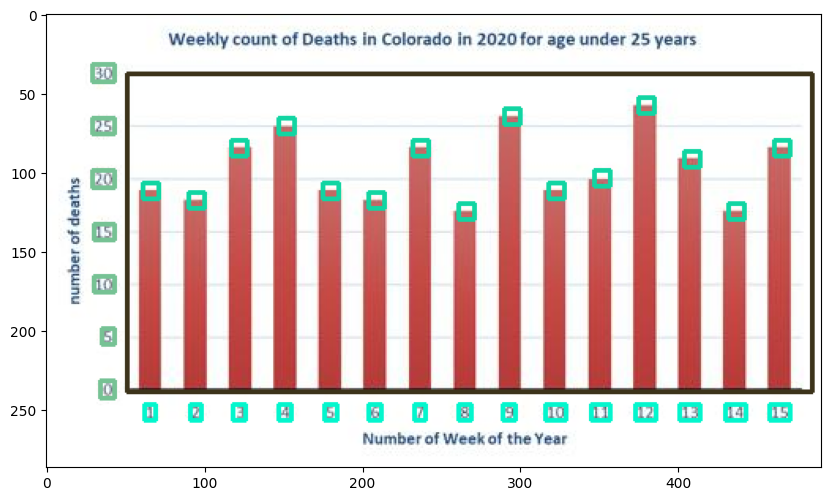

  8%|███████▌                                                                                    | 4950/60304 [00:12<02:15, 408.37it/s]

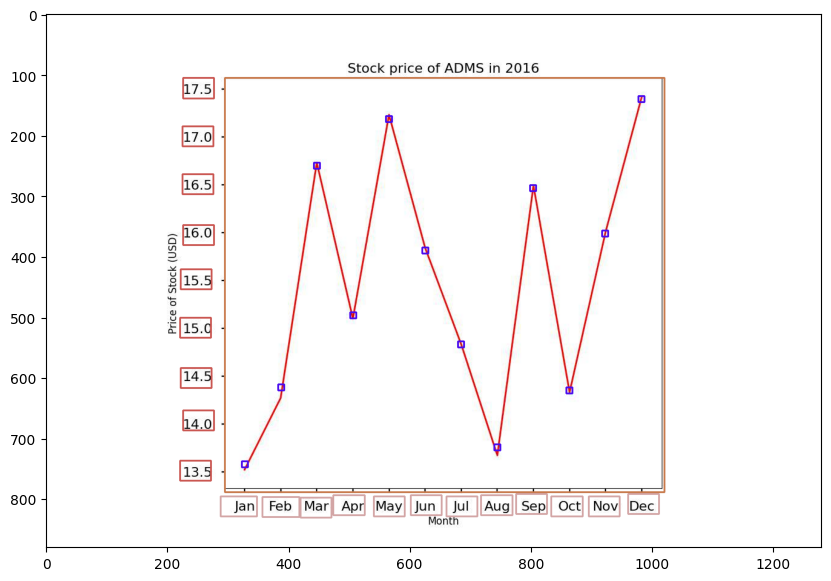

 13%|███████████▌                                                                                | 7574/60304 [00:19<02:08, 410.30it/s]

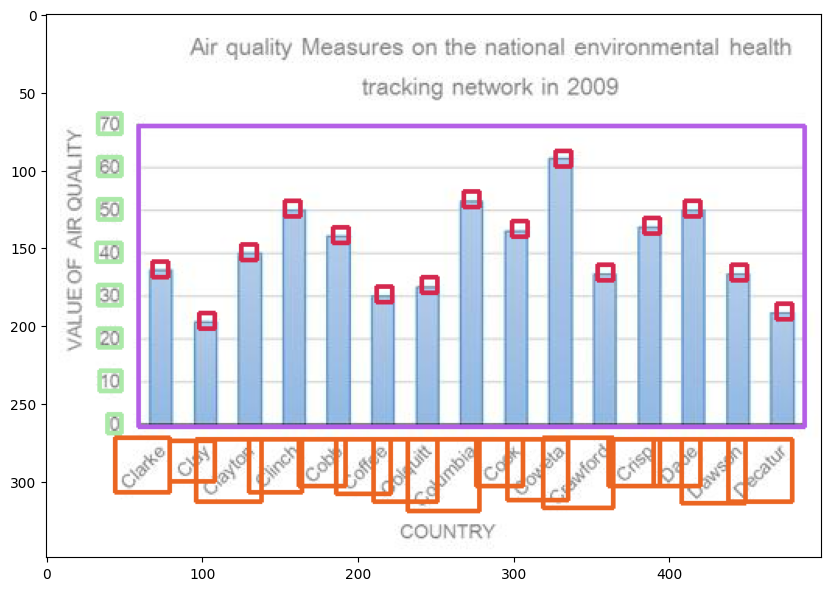

 33%|██████████████████████████████                                                             | 19910/60304 [00:48<01:40, 401.65it/s]

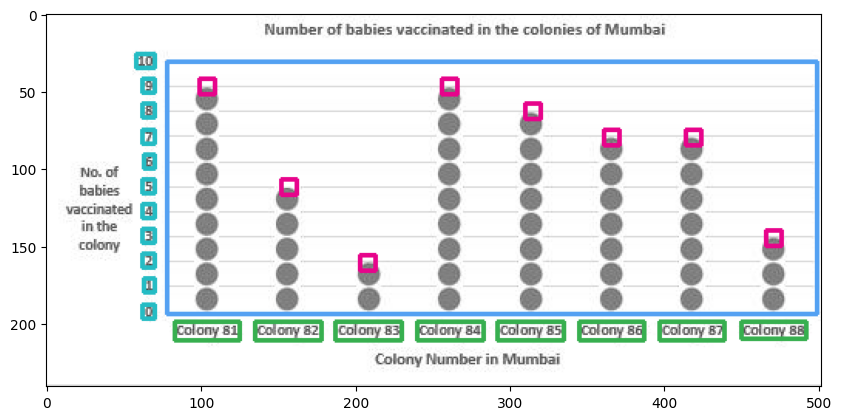

 41%|█████████████████████████████████████                                                      | 24566/60304 [01:00<01:27, 410.13it/s]

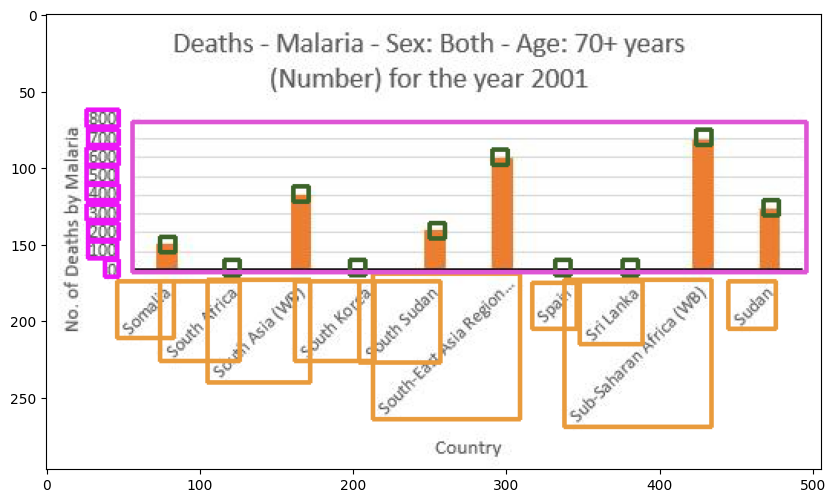

 55%|█████████████████████████████████████████████████▊                                         | 32977/60304 [01:20<01:03, 427.67it/s]

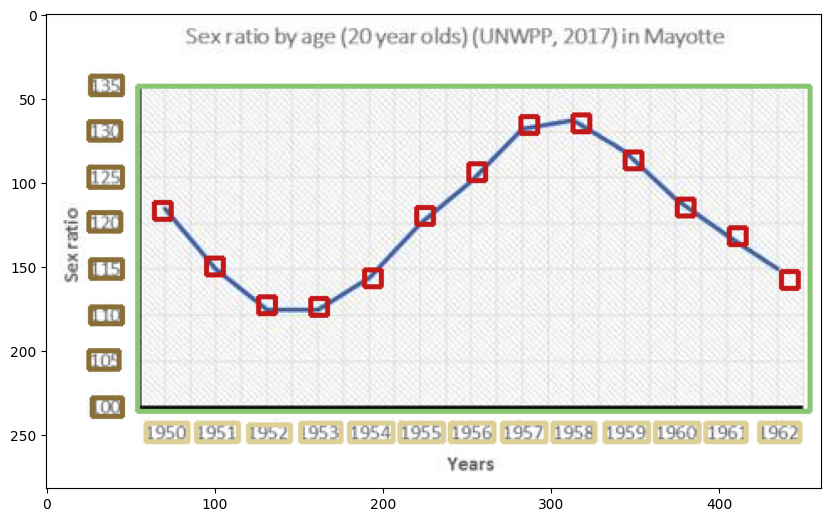

 69%|███████████████████████████████████████████████████████████████▏                           | 41907/60304 [01:42<00:45, 408.69it/s]

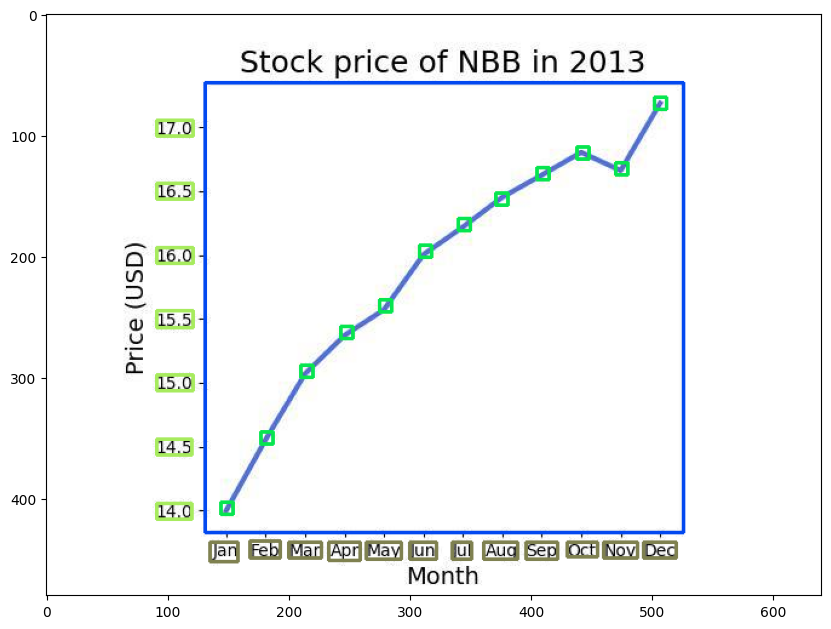

 72%|█████████████████████████████████████████████████████████████████▋                         | 43565/60304 [01:46<00:39, 428.57it/s]

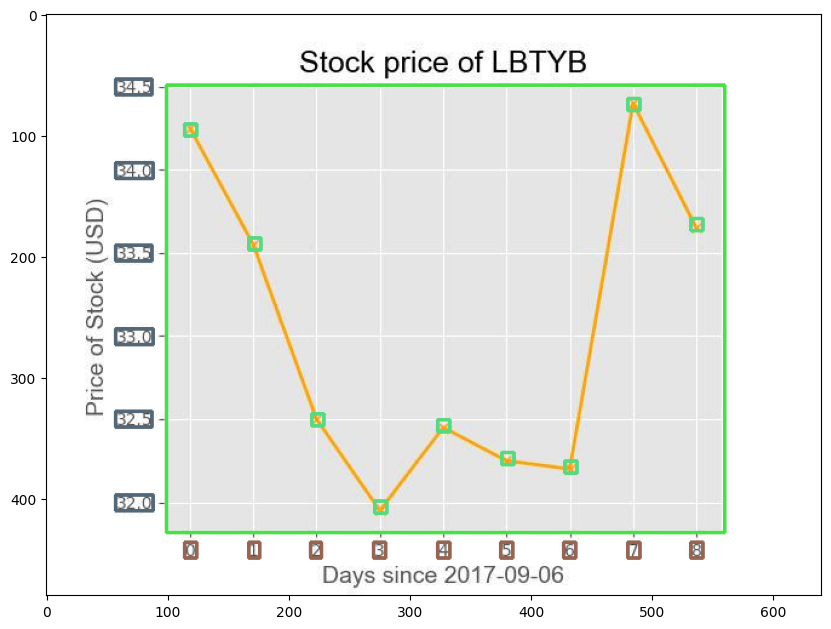

 73%|█████████████████████████████████████████████████████████████████▉                         | 43730/60304 [01:47<00:50, 327.49it/s]

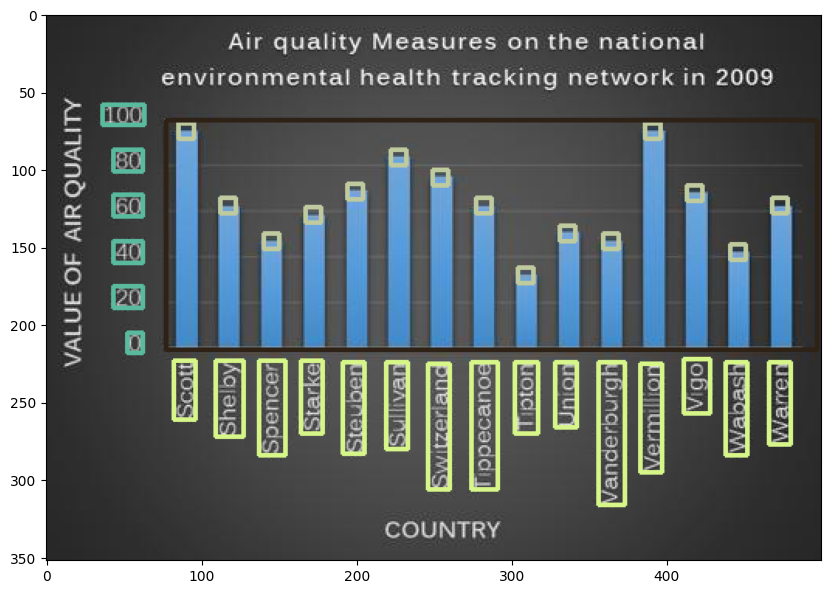

 74%|███████████████████████████████████████████████████████████████████▍                       | 44713/60304 [01:49<00:37, 417.21it/s]

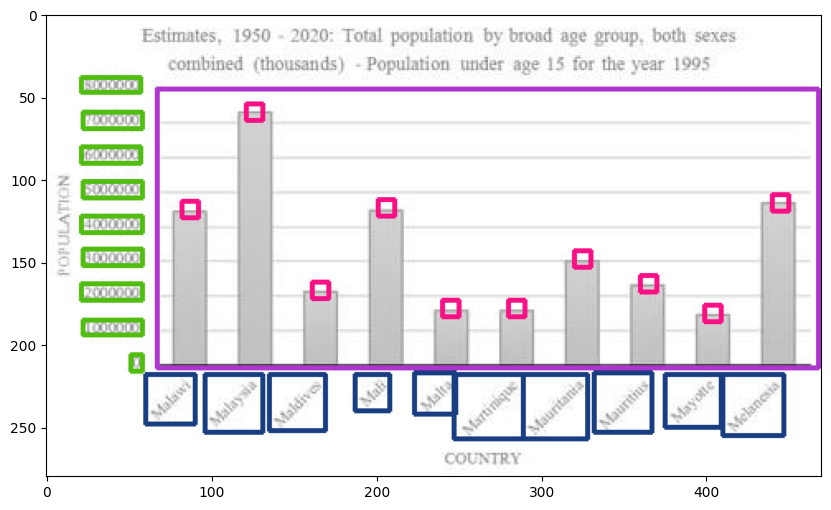

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 48914/60304 [02:00<00:28, 393.17it/s]

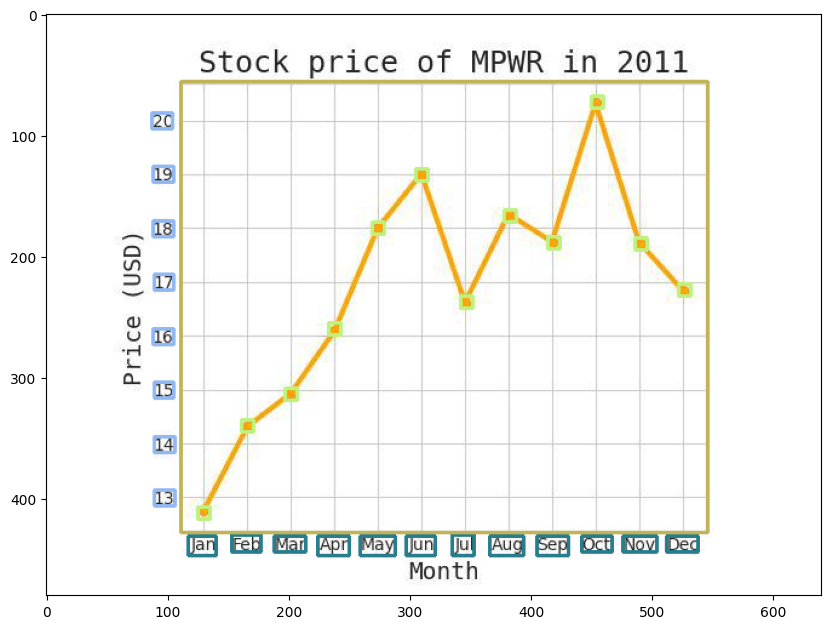

100%|███████████████████████████████████████████████████████████████████████████████████████████| 60304/60304 [02:28<00:00, 406.97it/s]

failed:  0


In [16]:
CINDEX={'line': 0, 'dot': 1, 'vertical_bar': 2, 'scatter': 3, 'horizontal_bar': 4}
ROOT="./dataset_ka/train/images/"
failed=0
TTH=10/len(train_files)
for k, v in tqdm(train_files.items()):
    try:
        imgpth=os.path.join(ROOT,k+".jpg")
        height,width=cv2.imread(os.path.join(ROOT,k+".jpg")).shape[:2]
        polygon = get_line_bboxes(v, v['chart-type'])
        h,w,x,y = list(v["plot-bb"].values())
        x = x+w/2
        y = y+h/2
        polygon.append([3+CINDEX[v['chart-type']],x,y,w,h])
        for i in range(len(polygon)):
            polygon[i][0] = str(polygon[i][0])
            x,y,w,h = polygon[i][1:]
            # x = x-w/2
            # y = y-h/2
            polygon[i][1] = str(x/width)
            polygon[i][3] = str(w/width)
            polygon[i][2] = str(y/height)
            polygon[i][4] = str(h/height)

        with open(f"./dataset/train/labels/{k}.txt", "w") as f:    
            f.write("\n".join([" ".join(p) for p in polygon]))
        shutil.copy(imgpth,"./dataset/train/images")
        if np.random.rand()<TTH:
            draw_boxes(imgpth, f"./dataset/train/labels/{k}.txt")
    except Exception as e:
        print(e)
        failed+=1
print("failed: ",failed)


  0%|                                                                                                          | 0/221 [00:00<?, ?it/s]

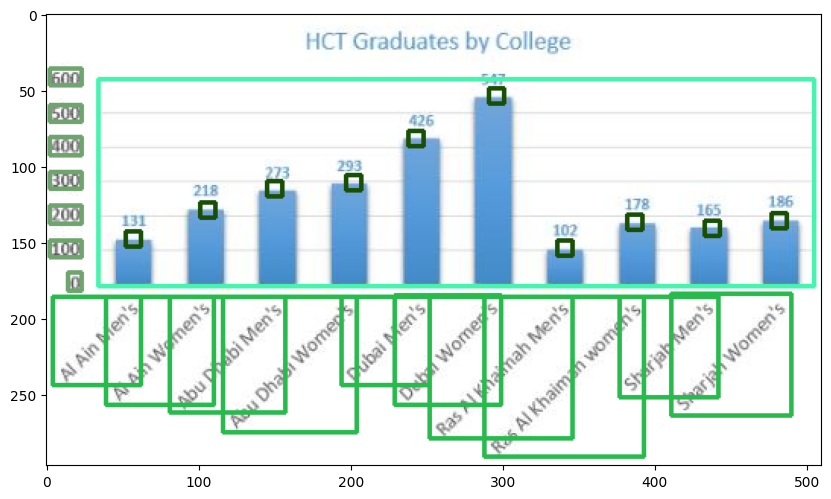

  3%|██▋                                                                                               | 6/221 [00:00<00:09, 22.99it/s]

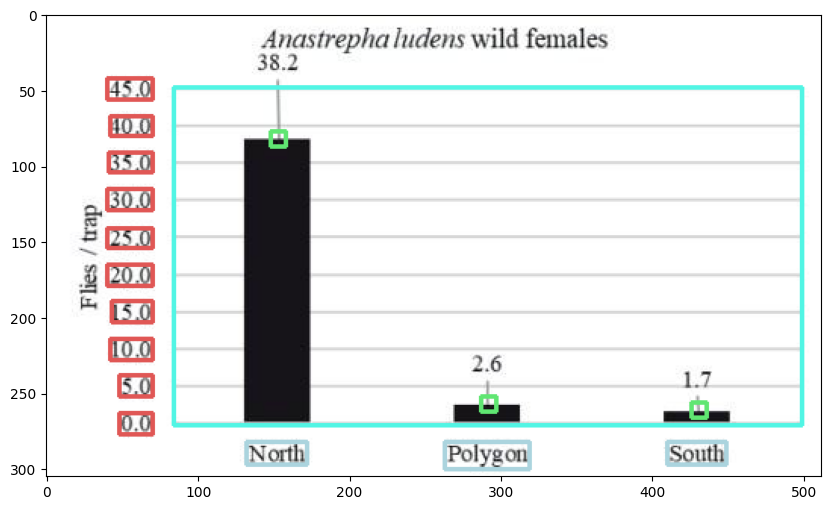

 21%|████████████████████▏                                                                            | 46/221 [00:00<00:05, 30.39it/s]

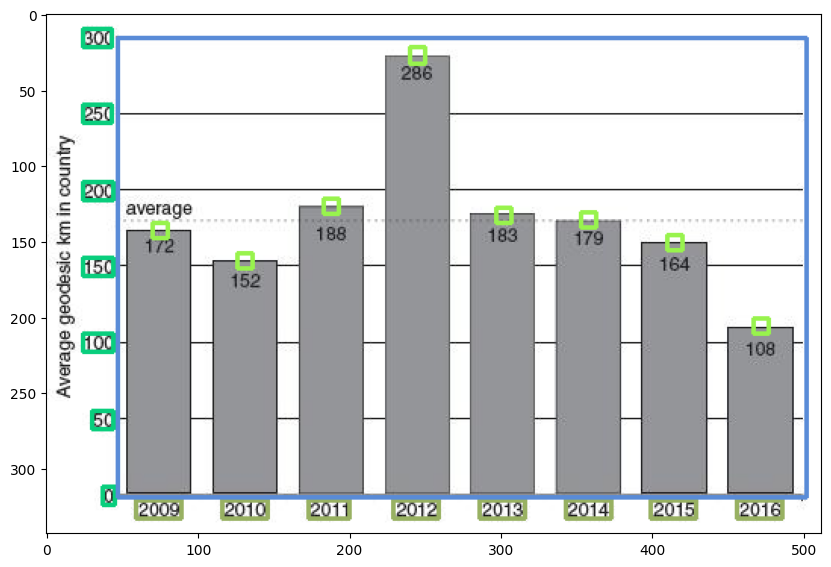

 23%|██████████████████████▍                                                                          | 51/221 [00:00<00:06, 26.24it/s]

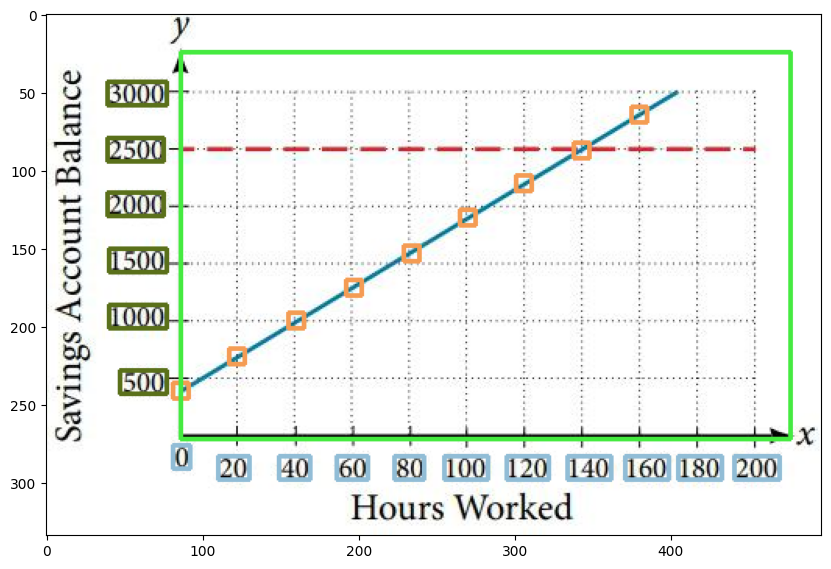

 38%|████████████████████████████████████▊                                                            | 84/221 [00:01<00:04, 33.46it/s]

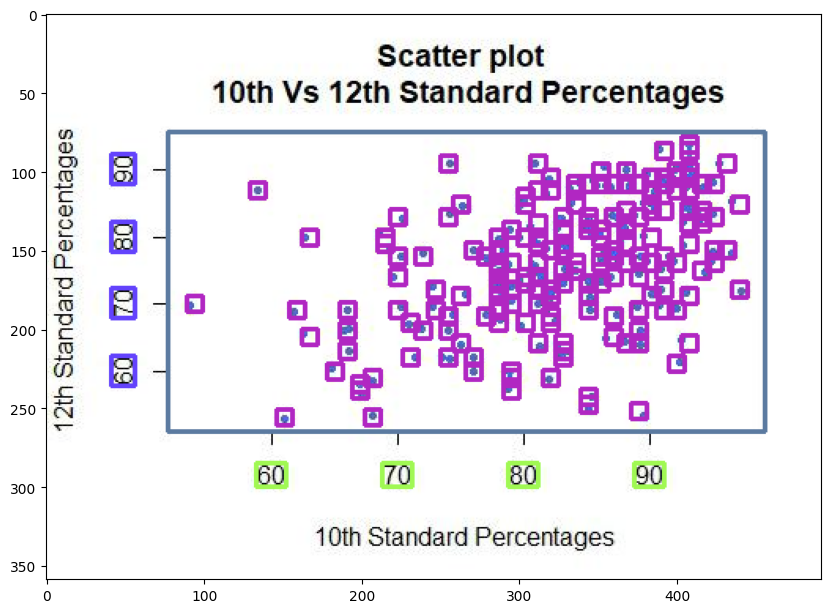

 48%|██████████████████████████████████████████████▍                                                 | 107/221 [00:01<00:02, 39.45it/s]

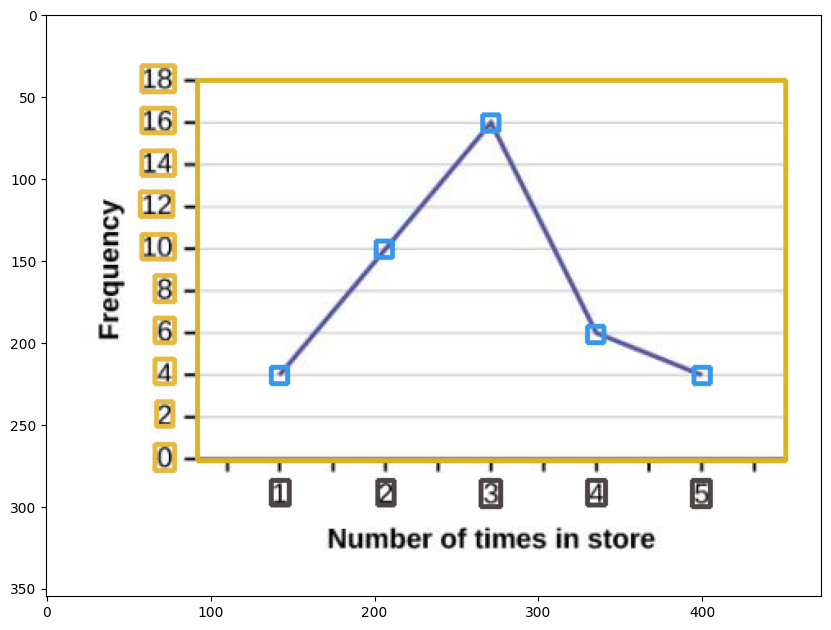

 60%|█████████████████████████████████████████████████████████▎                                      | 132/221 [00:01<00:01, 46.76it/s]

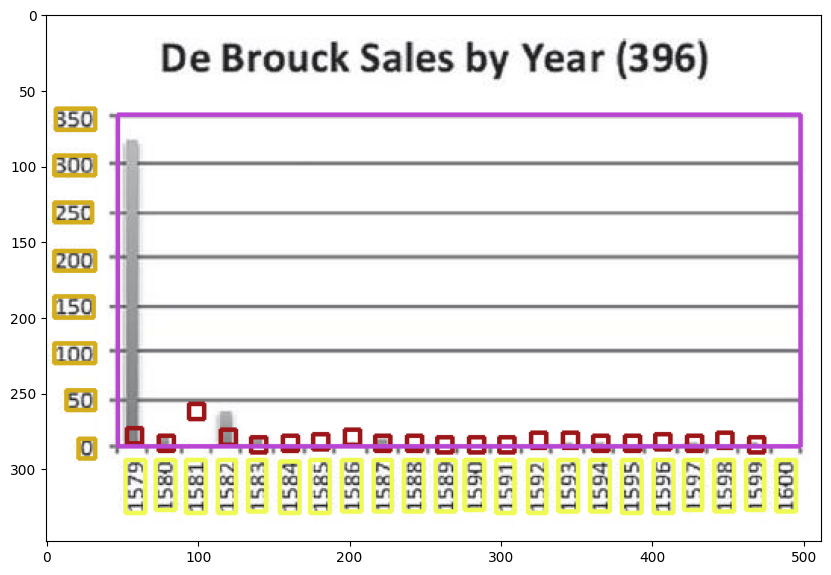

 75%|███████████████████████████████████████████████████████████████████████▋                        | 165/221 [00:02<00:01, 55.49it/s]

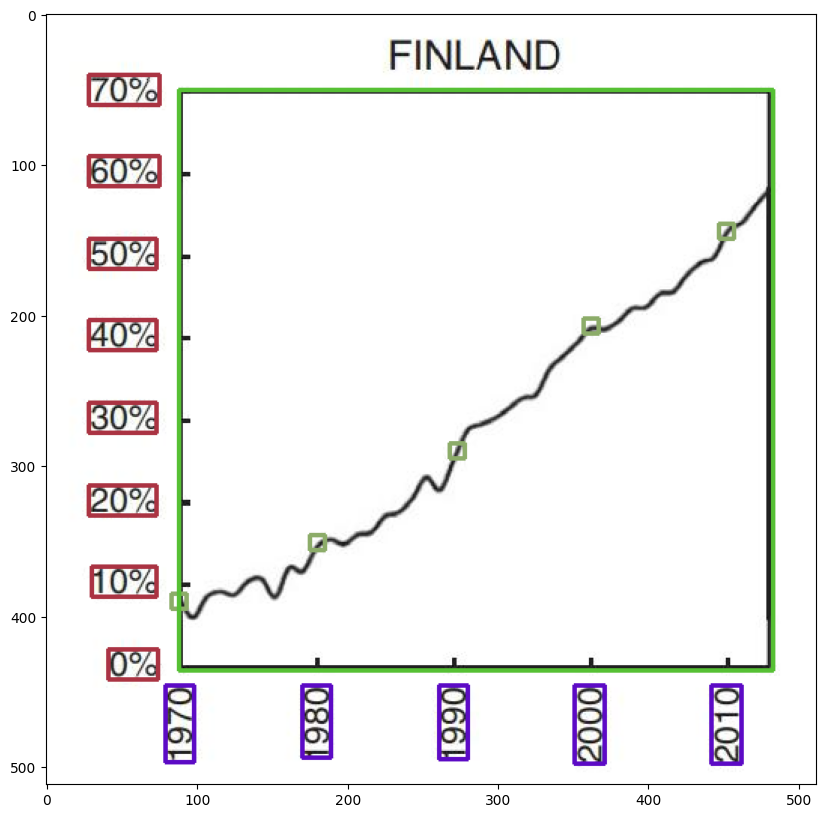

 82%|███████████████████████████████████████████████████████████████████████████████                 | 182/221 [00:02<00:00, 54.16it/s]

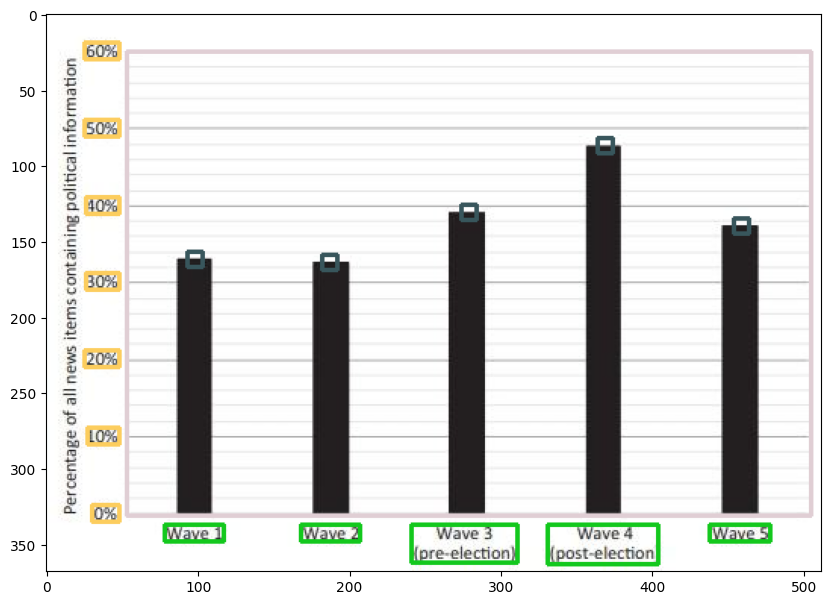

 92%|████████████████████████████████████████████████████████████████████████████████████████▏       | 203/221 [00:02<00:00, 57.79it/s]

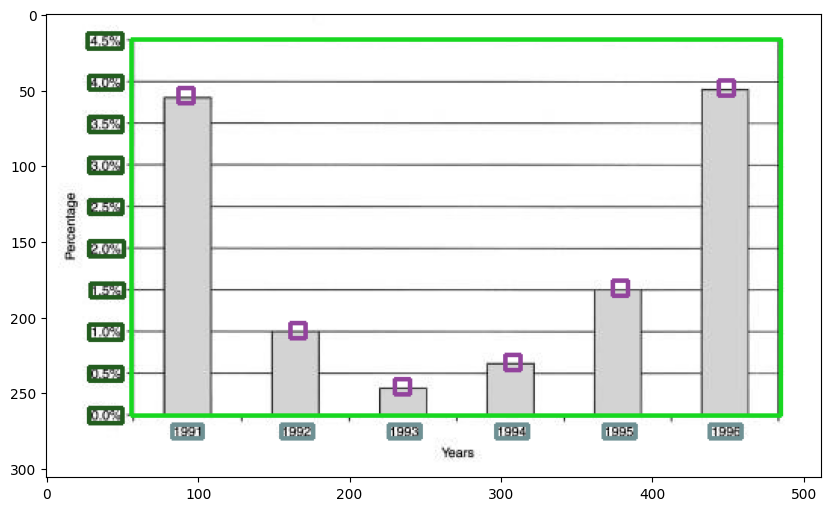

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:03<00:00, 71.78it/s]

failed:  0


In [17]:
CINDEX={'line': 0, 'dot': 1, 'vertical_bar': 2, 'scatter': 3, 'horizontal_bar': 4}
ROOT="./dataset_ka/train/images/"
failed=0
TTH=10/len(valid_files)
for k, v in tqdm(valid_files.items()):
    try:
        imgpth=os.path.join(ROOT,k+".jpg")
        height,width=cv2.imread(os.path.join(ROOT,k+".jpg")).shape[:2]
        polygon = get_line_bboxes(v, v['chart-type'])
        h,w,x,y = list(v["plot-bb"].values())
        x = x+w/2
        y = y+h/2
        polygon.append([3+CINDEX[v['chart-type']],x,y,w,h])
        for i in range(len(polygon)):
            polygon[i][0] = str(polygon[i][0])
            x,y,w,h = polygon[i][1:]
            # x = x-w/2
            # y = y-h/2
            polygon[i][1] = str(x/width)
            polygon[i][3] = str(w/width)
            polygon[i][2] = str(y/height)
            polygon[i][4] = str(h/height)

        with open(f"./dataset/valid/labels/{k}.txt", "w") as f:    
            f.write("\n".join([" ".join(p) for p in polygon]))
        shutil.copy(imgpth,"./dataset/valid/images")
        if np.random.rand()<TTH:
            draw_boxes(imgpth, f"./dataset/valid/labels/{k}.txt")
    except Exception as e:
        print(e)
        failed+=1
print("failed: ",failed)
